In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye import *
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# Reader
reader = DataReader(rel_dir='images', ext='jpg')

# Detector
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

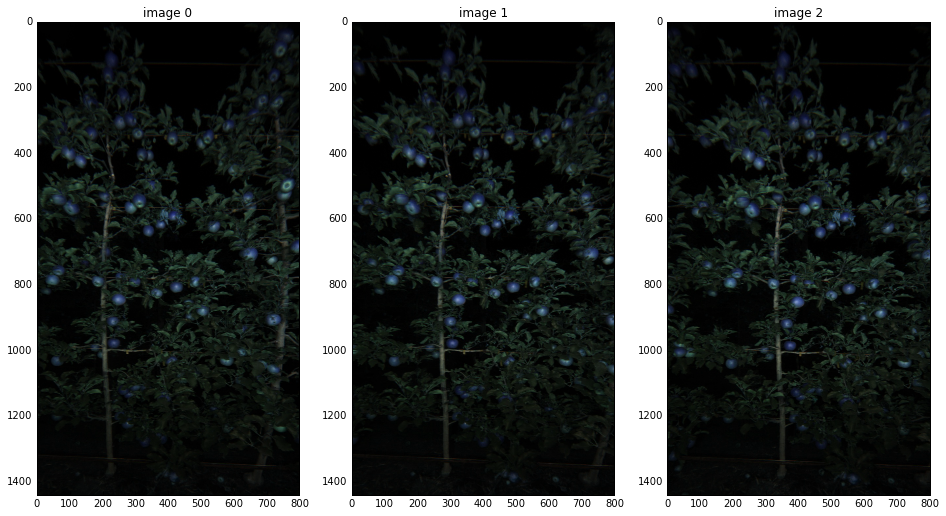

In [3]:
# Load n images
n = 3
images = []
for i in range(n):
    im = reader.read_image(i)
    im = rotate_image(im)
    im = im[:1440, 200:1000, :]
    images.append(im)

def plot_images(images):
    fig = plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(image)
        ax.set_title('image {0}'.format(i))

plot_images(images)

In [7]:
# Make a FruitTrack out of each detection
def bbox_center(bbox):
    x, y, w, h = bbox
    return np.array([x + w / 2, y + h / 2])

class FruitTrack(object):
    def __init__(self, blob, num_fruits=1):
        self.blob = blob
        self.num_fruits = 1
        self.kf = KalmanFilter(bbox_center(blob['bbox']))
    
    def predict(self, flow):
        # Note that this is the center of the bounding box
        p = self.kf.x
        p_pred = p + flow.ravel()
        _, _, w, h = self.blob['bbox']
        x, y = p_pred - np.array([w, h], float) / 2.0
        self.bbox_pred = np.array([x, y, w, h])
        
    
    def correct(self, blob):
        pass

def is_blob_multiple(blob):
    # For now just return false
    return False

#######################
# For now, we only care 
# about big blobs
#######################
def thresh_blobs_area(blobs, area=80):
    return blobs[blobs['area'] > area]

class Colors:
    bbox_detection = (255, 0, 0) # red
    bbox_prediction = (0, 0, 255) # blue
    optical_flow = (255, 0, 0) # red 
    bbox_prev = (255, 0, 255) # magenta
    bbox_match = (0, 255, 0) # green

12
number of blobs in image0: 12


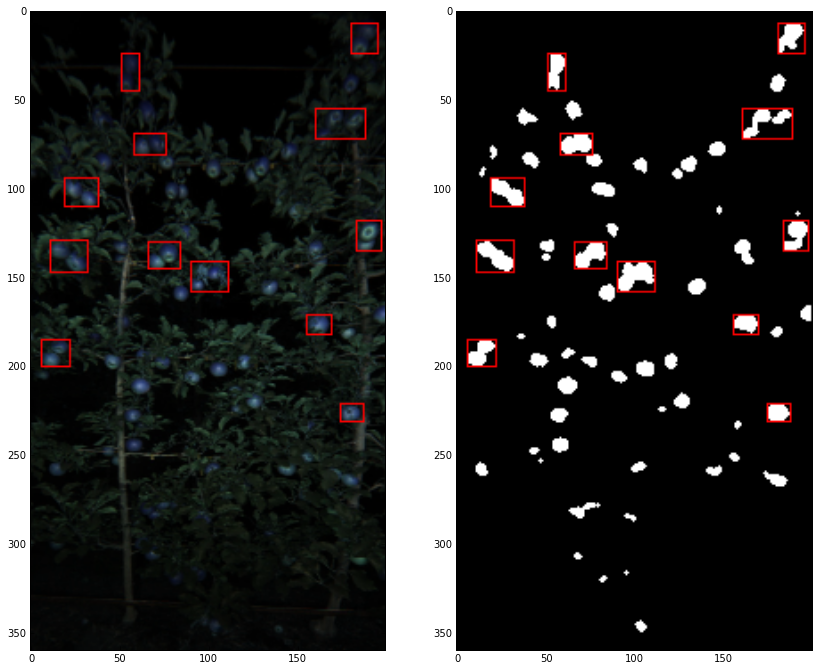

In [5]:
# We receive image0
image = images[0]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# We don't do optical flow because there's no previous image
prev_gray = None
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)

# initialize some new tracks and just be done
tracks = []
hsv = s.im_hsv

for blob in blobs:
    if is_blob_multiple(blob):
        bbox_region = extract_bbox(hsv, blob['bbox'])
        num_peaks = num_local_maximas(bbox_region)
    else:
        num_peaks = 1

    track = FruitTrack(blob, num_peaks)
    tracks.append(track)

print(len(tracks))

# Save the current detections
prev_gray = gray
prev_blobs = blobs

# Visualization
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.bbox_detection)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.bbox_detection)

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))

In [8]:
# We receive image1
image = images[1]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# Do optical flow stuff
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)
# This should be changed to bboxes that are tracked
prev_bboxes = prev_blobs['bbox']
p1s, p2s, sts = calc_bboxes_flow(prev_gray, gray, prev_bboxes)
flows = p2s - p1s

# Do some drawinngs
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_optical_flow(disp_color, p1s, p2s, color=Colors.optical_flow)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.bbox_detection)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.bbox_detection)

# Predict all valid tracks
print(len(tracks), len(prev_blobs))
valid_tracks = []
# All invalid tracks will be deleted at the end of each iterations
invalid_tracks = []
for track, flow, st in zip(tracks, flows, sts):
    # Only predict valid tracks
    if st == True:
        track.predict(flow)
        valid_tracks.append(track)
    else:
        invalid_tracks.append(track)
        
bboxes_pred = []
for track in valid_tracks:
    bboxes_pred.append(track.bbox_pred)
bboxes_pred = np.array(bboxes_pred)
draw_bboxes(disp_color, bboxes_pred, color=Colors.bbox_prediction)

# Do the assignment
bboxes_detect = blobs['bbox']
assignment_cost = bboxes_assignment_cost(bboxes_pred, bboxes_detect)
matches, un_pred, un_detect = hungarian_assignment(assignment_cost)
draw_bboxes_matches(disp_color, matches, bboxes_pred, bboxes_detect, color=Colors.bbox_match)

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))

(12, 12)


TypeError: integer argument expected, got float